In [1]:
## remove the views/ from the view_info.json file
import json
with open('view_info.json', 'r+') as f:
  data = json.load(f)
  for i in range(len(data)):
    data[i]['image'] = data[i]['image'].split('/')[-1]
  json.dump(data, f, indent=2)

In [1]:
import json
import argparse
import warnings
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%tb

args = argparse.Namespace(
    path='',
    train=False,
    eval=True,
    resume=False,
    cuda=True,
    batch_size=1,
    n_image_splits=1,
    print_epoch=True,
)

assert args.train or args.eval or args.resume, "You must provide one of --train, --eval or --resume"
assert sum(map(int, [args.train, args.eval, args.resume])) == 1, "You must only provide one of --train, --eval or --resume"

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load images
pics, cam_pos, cam_rot = [], [], []
'''json_fn = None
for fn in os.listdir(f"{args.path}/"):
    if fn.endswith('.json'):
        assert json_fn is None, "More than one json file in data directory. Remove all but the necessary one."
        json_fn = fn

assert json_fn is not None, "Could not find a json file containing dataset info"'''
json_fn = "view_info.json"

with open(f"{args.path}{json_fn}") as f:
    data_json = json.load(f)

for x in data_json:
    pic = Image.open(x["image"]).convert('RGB')
    pic = transform(pic).permute((2, 1, 0)).unsqueeze(0)
    pics.append(pic)
    pos = torch.tensor(list(map(float, x["position"].split(', '))))
    cam_pos.append(pos)
    rot = torch.tensor(list(map(float, x["rotation"].split(', '))))
    cam_rot.append(rot)

assert all([i.shape == j.shape for i, j in zip(pics, pics[1:])]), "Not all images have the same shape."
pics = torch.concat(pics)
cam_pos = torch.stack(cam_pos)
cam_rot = torch.stack(cam_rot)

if args.batch_size == -1:
    args.batch_size = pics.shape[0]
assert pics.shape[0] % args.batch_size == 0, f"Cannot divide {pics.shape[0]} images evenly into {args.batch_size} groups"
assert pics.shape[1] % args.n_image_splits == 0, f"Cannot horizontally divide images of horizontal size {pics.shape[1]} evenly into {args.n_image_splits} equal segments"


# define fourier input module
class FourierLayer(nn.Module):
    def __init__(self, fan_in: int, n_fourier_features: int, freq_spacing: str = 'logarithmic'):
        super().__init__()
        self.nff = n_fourier_features
        self.out_dim = 2 * fan_in * self.nff
        self.freq_spacing = freq_spacing

    def forward(self, x):
        x = x.view(x.shape + (1,))
        if self.freq_spacing == 'logarithmic':
            feature_mul = 2 ** torch.arange(0, self.nff, device=x.device)
        elif self.freq_spacing == 'linear':
            feature_mul = torch.arange(1, self.nff + 1, device=x.device)
        else:
            raise Exception(f'Unknown frequency spacing paradigm: {self.freq_spacing}')
        sines = torch.sin(x * feature_mul)
        cosines = torch.cos(x * feature_mul)
        # sines.shape = cosines.shape
        return torch.concat([sines.view(sines.shape + (1,)), cosines.view(cosines.shape + (1,))], dim=-1).flatten(-3, -1)


# load hyperparams from file
with open('hyperparameters.json') as f:
    hyperparams = argparse.Namespace(**json.load(f))

# define model input
# pure pixel position input + reshape
model_in = torch.concat([torch.arange(pics.shape[1]).unsqueeze(-1).repeat_interleave(pics.shape[2], dim=1).unsqueeze(-1), torch.arange(pics.shape[2]).unsqueeze(0).repeat_interleave(pics.shape[1], dim=0).unsqueeze(-1)], dim=-1) / torch.tensor(list(pics.shape[1:])[:-1]) * 2 - 1
model_in = model_in.unsqueeze(0).repeat_interleave(pics.shape[0], dim=0)
# reshape camera position and rotation
cam_pos = (cam_pos.view((cam_pos.shape[0], 1, 1, cam_pos.shape[1]))
           .repeat_interleave(model_in.shape[1], dim=1)
           .repeat_interleave(model_in.shape[2], dim=2))
cam_rot = (cam_rot.view((cam_rot.shape[0], 1, 1, cam_rot.shape[1]))
           .repeat_interleave(model_in.shape[1], dim=1)
           .repeat_interleave(model_in.shape[2], dim=2))
# concat
model_in = torch.concat([cam_pos, cam_rot, model_in], dim=-1)

# split model_in into pieces because it requires 600GiB GPU RAM otherwise D:
X = []
Y = []
x_batch_splits = model_in.split(args.batch_size)
y_batch_splits = pics.split(args.batch_size)

for x_batch_split, y_batch_split in zip(x_batch_splits, y_batch_splits):
    X.extend(x_batch_split.split(x_batch_split.shape[1] // args.n_image_splits, dim=1))
    Y.extend(y_batch_split.split(y_batch_split.shape[1] // args.n_image_splits, dim=1))
    del x_batch_split, y_batch_split

# define the model
if args.train:
    fourier_layer = FourierLayer(model_in.shape[-1], hyperparams.n_fourier_features, hyperparams.frequency_spacing)
    model = nn.Sequential(
        fourier_layer,
        nn.Linear(fourier_layer.out_dim, hyperparams.n_hidden),
        nn.ReLU(),
        nn.Linear(hyperparams.n_hidden, hyperparams.n_hidden),
        nn.ReLU(),
        nn.Linear(hyperparams.n_hidden, 3),
        nn.Tanh()
    )
else:
    model = torch.load('model.ckpt')

# define the optimizer
optim = torch.optim.AdamW(model.parameters(), hyperparams.lr)
pred = None

# move to gpu
if args.cuda:
    if torch.cuda.is_available():
        # model_in = model_in.to('cuda')  not used anymore!!!
        for i, x in enumerate(X):
            X[i] = x.to('cuda')
        for i, y in enumerate(Y):
            Y[i] = y.to('cuda')
        model = model.to('cuda')
        # pics = pics.to('cuda')  not used anymore!!!
        print('Moved parameters/IO to cuda')
    else:
        raise Exception('Cuda not available -> Failed to move parameters/IO to cuda')

# delete unnecessary variables for gpu memory
del transform, pics, cam_pos, cam_rot, model_in, x_batch_splits, y_batch_splits

# main training loop
if args.train or args.resume:
    for e in range(hyperparams.epochs):
        for i, x, y in zip(range(len(X)), X, Y):
            pred = (model(x) + 1) / 2
            loss = F.mse_loss(pred, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            if i % 100 == 0:
              print(f"Epoch {e} -> Step {i}")
else:
    pred = []
    for x in X:
        pred.append(((model(x) + 1) / 2).detach().to('cpu'))
    pred = torch.concat(pred)

if args.train or args.resume:
    torch.save(model, 'model.ckpt')


No traceback available to show.


Moved parameters/IO to cuda


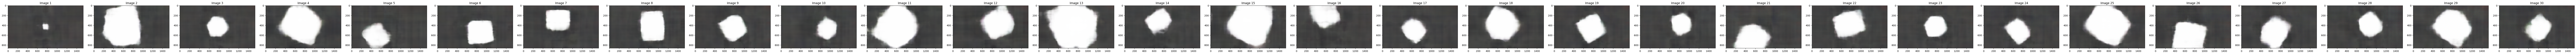

In [2]:

# show the result
imgs = pred.detach().to('cpu').transpose(2, 1).numpy()
imgs = [imgs[i] for i in range(imgs.shape[0])]
# Determine the number of images
num_images = len(imgs)

# Calculate the number of rows and columns for the grid
num_rows = 1
num_cols = num_images

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5))

# Plot each image in its respective subplot
for i in range(num_images):
    if num_images > 1:
        ax = axes[i]
    else:
        ax = axes  # Handle the case when there's only one image

    ax.imshow(imgs[i], cmap='gray')  # Display the image
    ax.set_title(f'Image {i+1}')  # Set the title for the subplot

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plot
plt.show()

# todo: inefficiencies >> loading images all into one tensor, then concat, then split, then convert to fourier representation. Could instead do concat on every single tensor and split etc individually and after one another to avoid having lots of temporary memory allocation at once
